<a href="https://colab.research.google.com/github/askgoliath/machine_learning/blob/master/loans_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#install/upgrade tensorflow if necessary and versions < 2
#!pip install --upgrade tensorflow-gpu

#Setup

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

In [2]:
#should be version 2+
print (tf.__version__)
print (keras.__version__)

2.0.0
2.2.4-tf


In [0]:
#import some libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

# Plotly visualizations
import chart_studio.plotly


from collections import Counter
import time

# To make this notebook's output stable across runs
np.random.seed(123)

def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

#Load Data

In [4]:
#run this to mount your drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
#data_folder = '/content/drive/My Drive/Machine learning UT/'
data_folder = '/content/drive/My Drive/Colab Notebooks/Final Project'
data_path =  os.path.join(data_folder, 'loan.csv')

loan = pd.read_csv(data_path, low_memory=False)
loan_orign=loan.copy()

loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0.0,Apr-2001,1.0,NaN,45.0,9.0,1.0,4341,10.3,34.0,w,2386.02,2386.02,167.02,167.02,...,1.0,0.0,60124.0,16901.0,36500.0,18124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0.0,Jun-1987,0.0,71.0,75.0,13.0,1.0,12315,24.2,44.0,w,29387.75,29387.75,1507.11,1507.11,...,1.0,0.0,372872.0,99468.0,15000.0,94072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,490xx,MI,10.51,0.0,Apr-2011,0.0,NaN,NaN,8.0,0.0,4599,19.1,13.0,w,4787.21,4787.21,353.89,353.89,...,0.0,0.0,136927.0,11749.0,13800.0,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,IT Supervisor,10+ years,MORTGAGE,92000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,985xx,WA,16.74,0.0,Feb-2006,0.0,NaN,NaN,10.0,0.0,5468,78.1,13.0,w,3831.93,3831.93,286.71,286.71,...,0.0,0.0,385183.0,36151.0,5000.0,44984.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,Mechanic,10+ years,MORTGAGE,57250.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,212xx,MD,26.35,0.0,Dec-2000,0.0,NaN,NaN,12.0,0.0,829,3.6,26.0,w,29339.02,29339.02,1423.21,1423.21,...,0.0,0.0,157548.0,29674.0,9300.0,32332.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


#Some Pre-Processing

In [7]:
dict_path =  os.path.join(data_folder, 'LCDataDictionary.xlsx')
meta = pd.read_excel(dict_path, sheet_name="LoanStats", dtype={'drop':bool} )
meta.head()

,drop,name,description
0,False,acc_now_delinq,The number of accounts on which the borrower i...
1,False,acc_open_past_24mths,Number of trades opened in past 24 months.
2,False,addr_state,The state provided by the borrower in the loan...
3,False,all_util,Balance to credit limit on all trades
4,False,annual_inc,The self-reported annual income provided by th...


In [8]:
columns_to_drop = meta[meta['drop'] == True]['name']
columns_to_drop

15                                           desc
18                               earliest_cr_line
27                                             id
29                            initial_list_status
35                                        issue_d
36                             last_credit_pull_d
44                                      member_id
58                                   next_pymnt_d
84                                    policy_code
95                                          title
111                                           url
118                      sec_app_earliest_cr_line
129                                 hardship_type
134                           hardship_start_date
135                             hardship_end_date
136                       payment_plan_start_date
140    orig_projected_additional_accrued_interest
145                     debt_settlement_flag_date
147                               settlement_date
Name: name, dtype: object

In [0]:
loan.drop(labels=columns_to_drop, axis=1, inplace=True)

In [9]:
#check loan status counts and us to define good loans and bad loans
loan["loan_status"].value_counts()

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

In [0]:
def define_status(status):
  """define good and bad loans based on loan_status"""
  bad_loans = ["Charged Off","Late (31-120 days)","In Grace Period","Late (16-30 days)","Does not meet the credit policy. Status:Fully Paid"
            ,"Does not meet the credit policy. Status:Charged Off","Default"]
  if status in bad_loans:
      return 'Bad Loan'
  else:
      return 'Good Loan'

def define_loan_conditions(l):
  """define loan_conditions column from good and bad loans status"""
  l['loan_conditions'] = l['loan_status'].apply(define_status)

In [0]:
define_loan_conditions(loan)

#Visualize / Explore Dataset

In [0]:
#visuliaze on what amount loan is most often approvided by company
loan_amount = loan["loan_amnt"].values
funded_amount = loan["funded_amnt"].values
investor_funds = loan["funded_amnt_inv"].values

fig, ax = plt.subplots(1, 3, figsize=(17,7))

sns.distplot(loan_amount, ax=ax[0], color="y")
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)
sns.distplot(funded_amount, ax=ax[1], color="r")
ax[1].set_title("Amount Funded by the Lender", fontsize=14)
sns.distplot(investor_funds, ax=ax[2], color="c")
ax[2].set_title("Total committed by Investors", fontsize=14)
    
# we can see amount around 10000 is funded most often
#3 amounts are almost exactly same, we will just use one amount that is funded_amt

In [0]:
#look into good loans vs bad loands, want to know the ratio between them. then when we build model we can ignore some bias
#we can draw a pie plot to see the ratio.
plt.subplots( figsize=(17,10))
colors = ["#eeefff", "y"]
labels ="Good Loans", "Bad Loans"



loan["loan_conditions"].value_counts()
.plot.pie(explode=[0,0.25],autopct='%1.2f%%', shadow=True, colors=colors, 
          labels=labels, fontsize=12, startangle=70)



In [0]:
#Want to investigate in what the purpose of loan is
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import plot, iplot

loan['purpose'].value_counts()
purpose_condition=round(pd.crosstab(loan['loan_conditions'],loan['purpose']).apply(lambda x :x/x.sum()*100),2)
purpose_bad_loans=purpose_condition.values[0].tolist()
purpose_good_loans=purpose_condition.values[1].tolist()
purpose_columns=purpose_condition.columns #create column names

good_loan_graph=go.Bar(x=purpose_columns,y=purpose_good_loans,name='Good loans',text='%',
        marker=dict(
        color='green',
        line = dict(
            color='green',
            width=2)))
bad_loan_graph=go.Bar(x=purpose_columns,y=purpose_bad_loans,name='bad loans',text='%',
        marker=dict(
        color='red',
        line = dict(
            color='red',
            width=2)))
combined_Data=[good_loan_graph,bad_loan_graph]
layout = go.Layout(
    title='Condition of Loan by Purpose',
    xaxis=dict(
        title=''
    ),
    yaxis=dict(
        title='% of the Loan',
    ),
    paper_bgcolor='#FFF8DC',
    plot_bgcolor='#FFF8DC',
    showlegend=True
)
fig = dict(data=combined_Data, layout=layout)
iplot(fig, filename='condition_purposes')


# Clean Up Data

In [0]:
columns_default_na_to_zero = ['sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_open_act_il', 
 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'mths_since_recent_bc_dlq',
 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 
  'hardship_amount', 'hardship_length', 'hardship_payoff_balance_amount', 
 'hardship_last_payment_amount', 'settlement_amount', 'settlement_percentage', 
 'mths_since_recent_revol_delinq', 'revol_bal_joint', 'sec_app_revol_util', 'dti_joint',
 'sec_app_inq_last_6mths', 'deferral_term', 'annual_inc']

columns_default_na_to_negativeone = ['hardship_dpd', 'settlement_term', 'mths_since_last_delinq',
                                     'mths_since_last_record', 'mths_since_last_major_derog', 
                                     ]

columns_default_na_to_none = ['hardship_reason', 'hardship_status', 'hardship_loan_status', 
                              'settlement_status']

columns_default_na_to_specific = {'verification_status_joint':'Not Verified', 
                                  'emp_title': "UNKNOWN", 'emp_length': "UNKNOWN"}

In [0]:
def fillna_cols(x, cols, value):
  """set na values in specified cols in x dataframe to specified value"""
  x[cols] = x[cols].fillna(value)

In [0]:
fillna_cols(loan, columns_default_na_to_zero, 0)
fillna_cols(loan, columns_default_na_to_negativeone, -1)
fillna_cols(loan, columns_default_na_to_none, "NONE")

#if joint inc is na, set to main annual inc
loan.annual_inc_joint.fillna(loan.annual_inc, inplace=True) 

loan.fillna(columns_default_na_to_specific, inplace=True)

In [15]:
print_full(loan[columns_default_na_to_zero + 
                columns_default_na_to_negativeone+
                columns_default_na_to_none]
           .isna().sum().sort_values())

sec_app_mort_acc                       0
hardship_status                        0
hardship_reason                        0
mths_since_last_major_derog            0
mths_since_last_record                 0
mths_since_last_delinq                 0
settlement_term                        0
hardship_dpd                           0
annual_inc                             0
deferral_term                          0
sec_app_inq_last_6mths                 0
dti_joint                              0
sec_app_revol_util                     0
revol_bal_joint                        0
mths_since_recent_revol_delinq         0
settlement_percentage                  0
settlement_amount                      0
hardship_last_payment_amount           0
hardship_payoff_balance_amount         0
hardship_length                        0
hardship_amount                        0
sec_app_mths_since_last_major_derog    0
sec_app_collections_12_mths_ex_med     0
mths_since_recent_bc_dlq               0
sec_app_chargeof

Good loans are represented in the data more than bad loans, so we remove some good loans to balance it out, consequently speeding up training as well.

In [0]:
#make sure good and bad loans are even
bad_loans = loan[loan["loan_conditions"]=="Bad Loan"]
good_loans = loan[loan["loan_conditions"]=="Good Loan"]
good_loans_sampled = good_loans.sample(n = int(len(bad_loans))) 

loan = good_loans_sampled.append(bad_loans, ignore_index = True) 

In [0]:
def define_good_loan(status):
  """define good_loan column with values that can be used as label"""
  if status in 'Good Loan':
      return 1
  else:
      return 0

loan['good_loan'] = loan['loan_conditions'].apply(define_good_loan)

In [33]:
corr_with_good_loan = loan.corrwith(loan["good_loan"])
corr_pos = corr_with_good_loan[corr_with_good_loan > 0].sort_values(ascending=False)[:6]
corr_neg = corr_with_good_loan[corr_with_good_loan < 0].sort_values()[:5]

print(corr_pos)
print(corr_neg)

good_loan          1.000000
total_rec_prncp    0.362267
last_pymnt_amnt    0.329140
out_prncp          0.265445
out_prncp_inv      0.265423
total_pymnt_inv    0.220924
dtype: float64
recoveries                -0.401212
collection_recovery_fee   -0.378663
int_rate                  -0.293748
settlement_percentage     -0.250827
settlement_term           -0.218352
dtype: float64


In [0]:
def drop_mostly_na_cols(data,ratio,should_drop=False ) :
  if should_drop is False:
    return data
  count = len(data)
  mostly_na_cols = []
  for col in data:
    sum_na = data[col].isna().sum()
    if sum_na > 0 :
      na_ratio = round(sum_na / count, 2)
      #print(col)
      #print(f"\t\t\t\t { na_ratio }")
      if na_ratio > ratio :
        mostly_na_cols.append(col)
  print(mostly_na_cols)
  print(len(mostly_na_cols))
  return data.drop(mostly_na_cols, axis=1)


In [19]:
#drop other rows that don't have much info / mostly nulls
loan = drop_mostly_na_cols(loan,0.6,should_drop=True)
loan.head()

[]
0


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,collections_12_mths_ex_med,...,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_length,hardship_dpd,hardship_loan_status,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,settlement_status,settlement_amount,settlement_percentage,settlement_term,loan_conditions,good_loan
0,12000,12000,12000.0,36 months,7.21,371.68,A,A3,Supervisor,4 years,RENT,55120.0,Verified,Fully Paid,n,other,801xx,CO,6.71,0.0,0.0,-1.0,-1.0,4.0,0.0,2708,27.1,5.0,0.00,0.00,12749.134208,12749.13,12000.00,749.13,0.0,0.0,0.0,Sep-2018,8665.46,0.0,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,21592.0,11140.0,10000.0,11592.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N,NONE,NONE,0.0,0.0,0.0,-1.0,NONE,0.0,0.0,Cash,N,NONE,0.0,0.0,-1.0,Good Loan,1
1,30000,30000,30000.0,36 months,9.75,964.50,B,B3,Financial advisor,10+ years,RENT,261000.0,Source Verified,Fully Paid,n,debt_consolidation,970xx,OR,11.44,0.0,0.0,-1.0,-1.0,9.0,0.0,31847,55.8,23.0,0.00,0.00,31959.004691,31959.00,30000.00,1959.00,0.0,0.0,0.0,Dec-2016,24275.50,0.0,...,0.0,0.0,0.0,3.0,100.0,100.0,0.0,0.0,128411.0,81496.0,30500.0,71311.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N,NONE,NONE,0.0,0.0,0.0,-1.0,NONE,0.0,0.0,Cash,N,NONE,0.0,0.0,-1.0,Good Loan,1
2,1500,1500,1500.0,36 months,11.49,49.46,B,B5,Quality Specialist,9 years,MORTGAGE,39800.0,Source Verified,Current,n,debt_consolidation,752xx,TX,14.81,0.0,0.0,-1.0,-1.0,8.0,0.0,1775,37.8,16.0,558.05,558.05,1185.120000,1185.12,941.95,243.17,0.0,0.0,0.0,Feb-2019,49.46,0.0,...,0.0,0.0,0.0,4.0,100.0,0.0,0.0,0.0,80737.0,8275.0,1600.0,7525.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N,NONE,NONE,0.0,0.0,0.0,-1.0,NONE,0.0,0.0,Cash,N,NONE,0.0,0.0,-1.0,Good Loan,1
3,7000,7000,7000.0,36 months,13.99,239.21,C,C3,Mail supporting clrrk,7 years,OWN,40000.0,Source Verified,Current,n,debt_consolidation,319xx,GA,34.11,0.0,1.0,-1.0,-1.0,11.0,0.0,28932,81.0,26.0,1599.01,1599.01,6950.550000,6950.55,5400.99,1549.56,0.0,0.0,0.0,Feb-2019,239.21,0.0,...,0.0,0.0,0.0,0.0,100.0,80.0,0.0,0.0,35700.0,28932.0,34800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N,NONE,NONE,0.0,0.0,0.0,-1.0,NONE,0.0,0.0,Cash,N,NONE,0.0,0.0,-1.0,Good Loan,1
4,35000,35000,35000.0,36 months,11.99,1162.34,C,C1,Credit Analyst,7 years,RENT,75000.0,Source Verified,Fully Paid,n,debt_consolidation,336xx,FL,23.86,0.0,0.0,-1.0,-1.0,20.0,0.0,35675,47.3,33.0,0.00,0.00,41213.985244,41213.99,35000.00,6213.99,0.0,0.0,0.0,May-2018,12178.80,0.0,...,0.0,0.0,0.0,4.0,100.0,10.0,0.0,0.0,102353.0,53095.0,60300.0,25908.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N,NONE,NONE,0.0,0.0,0.0,-1.0,NONE,0.0,0.0,Cash,N,NONE,0.0,0.0,-1.0,Good Loan,1


# Build Transformation Pipeline

In [0]:
numeric_columns = list(set(list(loan.select_dtypes(np.number).columns))
                      - set(['good_loan', 'loan_conditions', 'loan_status']))
categorical_columns = list( set(loan.columns) - set(numeric_columns) 
                      - set(['good_loan', 'loan_conditions', 'loan_status']))                

In [115]:
loan[numeric_columns].describe()

,total_acc,num_bc_sats,sec_app_open_act_il,tot_coll_amt,total_cu_tl,num_accts_ever_120_pd,mths_since_last_major_derog,open_acc,sec_app_mths_since_last_major_derog,revol_bal_joint,mths_since_recent_bc,mo_sin_old_il_acct,pub_rec_bankruptcies,total_il_high_credit_limit,bc_open_to_buy,settlement_amount,total_bal_ex_mort,total_bc_limit,hardship_last_payment_amount,mths_since_last_record,open_rv_12m,settlement_percentage,sec_app_revol_util,hardship_payoff_balance_amount,out_prncp,num_actv_rev_tl,deferral_term,mo_sin_rcnt_rev_tl_op,num_op_rev_tl,avg_cur_bal,sec_app_inq_last_6mths,num_sats,revol_util,settlement_term,inq_last_6mths,inq_last_12m,il_util,num_bc_tl,annual_inc,acc_now_delinq,...,mo_sin_old_rev_tl_op,delinq_amnt,delinq_2yrs,mths_since_recent_revol_delinq,collections_12_mths_ex_med,sec_app_open_acc,collection_recovery_fee,dti_joint,mths_since_recent_inq,num_tl_120dpd_2m,pct_tl_nvr_dlq,int_rate,num_tl_op_past_12m,dti,recoveries,sec_app_num_rev_accts,sec_app_collections_12_mths_ex_med,num_actv_bc_tl,mths_since_last_delinq,mths_since_rcnt_il,bc_util,all_util,hardship_length,mort_acc,tax_liens,num_rev_accts,num_il_tl,total_rec_late_fee,installment,total_pymnt_inv,percent_bc_gt_75,acc_open_past_24mths,sec_app_chargeoff_within_12_mths,open_il_12m,num_rev_tl_bal_gt_0,chargeoff_within_12_mths,num_tl_30dpd,out_prncp_inv,total_rev_hi_lim,last_pymnt_amnt
count,672768.000000,652711.000000,672797.000000,6.488280e+05,383005.000000,648828.000000,672797.000000,672768.000000,672797.000000,672797.000000,648327.000000,628228.000000,671903.000000,6.488280e+05,647822.000000,672797.000000,6.554460e+05,6.554460e+05,672797.000000,672797.000000,383006.000000,672797.000000,672797.000000,672797.000000,672797.000000,648828.000000,672797.000000,648827.000000,648828.000000,648806.000000,672797.000000,652711.000000,672231.000000,672797.000000,672767.000000,383005.000000,329312.000000,648828.000000,6.727970e+05,672768.000000,...,648827.000000,672768.000000,672768.000000,672797.000000,672689.000000,672797.000000,672797.000000,672797.000000,591333.000000,620668.000000,648769.000000,672797.000000,648828.000000,672385.000000,672797.000000,672797.000000,672797.000000,648828.000000,672797.000000,370815.000000,647459.000000,382941.000000,672797.000000,655446.000000,672720.000000,648828.000000,648828.000000,6.727970e+05,672797.000000,672797.000000,647679.000000,655446.000000,672797.000000,383006.000000,648828.000000,672689.000000,648828.000000,672797.000000,6.488280e+05,672797.000000
mean,24.294458,4.784136,0.121609,2.611796e+02,1.487691,0.514130,11.036831,11.698490,0.505653,1330.108908,23.455892,124.858878,0.136807,4.331435e+04,10113.708400,246.988224,5.058676e+04,2.157800e+04,2.069714,11.420253,1.375508,2.345448,2.328692,123.222094,3310.017109,5.784971,0.031021,13.162687,8.343877,12703.068854,0.028245,11.721203,51.806788,-0.305233,0.654112,2.201047,70.374177,7.770401,7.555474e+04,0.004649,...,178.126838,15.296411,0.323336,11.879238,0.019256,0.455712,75.915787,0.897654,6.680698,0.000722,94.019823,14.031100,2.215425,19.270415,457.222806,0.495878,0.003903,3.725235,16.547739,20.521433,59.801424,58.402913,0.031021,1.489409,0.050925,14.134994,8.495549,2.989397e+00,453.589007,10553.254258,44.922556,4.791836,0.002293,0.725589,5.725713,0.009034,0.003138,3309.267966,3.260249e+04,2324.495330
std,12.054218,3.038161,0.892660,1.535939e+04,2.685163,1.350481,22.798197,5.664296,5.104414,8580.742973,31.016857,53.853546,0.378416,4.414732e+04,15245.161014,1360.174201,4.860755e+04,2.172168e+04,28.662836,29.496727,1.567301,10.448659,12.597784,1433.932408,6806.394776,3.452394,0.303482,16.656150,4.706202,15549.929019,0.254345,5.664463,24.549679,3.555924,0.968514,2.507816,23.589597,4.721965,1.051781e+05,0.073186,...,96.534740,835.556203,0.892164,21.170640,0.152058,2.598458,224.147799,4.425334,5.862324,0.028880,9.010728,5.021657,1.895889,13.049290,1274.117030,2.919927,0.092187,2.343170,23.437560,25.924007,28.413787,20.799880,0.303482,1.877394,0.399324,8.086234,7.472708,1.639780e+01,266.7

In [116]:
loan[categorical_columns]

,purpose,hardship_status,term,debt_settlement_flag,sub_grade,settlement_status,addr_state,hardship_loan_status,hardship_reason,application_type,verification_status_joint,hardship_flag,verification_status,pymnt_plan,last_pymnt_d,emp_length,grade,disbursement_method,home_ownership,zip_code,emp_title
0,other,NONE,36 months,N,A3,NONE,CO,NONE,NONE,Individual,Not Verified,N,Verified,n,Sep-2018,4 years,A,Cash,RENT,801xx,Supervisor
1,debt_consolidation,NONE,36 months,N,B3,NONE,OR,NONE,NONE,Individual,Not Verified,N,Source Verified,n,Dec-2016,10+ years,B,Cash,RENT,970xx,Financial advisor
2,debt_consolidation,NONE,36 months,N,B5,NONE,TX,NONE,NONE,Individual,Not Verified,N,Source Verified,n,Feb-2019,9 years,B,Cash,MORTGAGE,752xx,Quality Specialist
3,debt_consolidation,NONE,36 months,N,C3,NONE,GA,NONE,NONE,Individual,Not Verified,N,Source Verified,n,Feb-2019,7 years,C,Cash,OWN,319xx,Mail supporting clrrk
4,debt_consolidation,NONE,36 months,N,C1,NONE,FL,NONE,NONE,Individual,Not Verified,N,Source Verified,n,May-2018,7 years,C,Cash,RENT,336xx,Credit Analyst
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672792,debt_consolidation,NONE,36 months,N,D1,NONE,VA,NONE,NONE,Individual,Not Verified,N,Source Verified,n,Nov-2018,10+ years,D,Cash,MORTGAGE,233xx,Supervisor
672793,debt_consolidation,NONE,60 months,N,C1,NONE,IN,NONE,NONE,Individual,Not Verified,N,Verified,n,Sep-2018,10+ years,C,Cash,OWN,461xx,Dental Assistant
672794,debt_consolidation,NONE,60 months,N,D1,NONE,NY,NONE,NONE,Individual,Not Verified,N,Not Verified,n,Jun-2018,2 years,D,Cash,RENT,112xx,Senior Manager
672795,debt_consolidation,NONE,60 months,N,F4,NONE,TX,NONE,NONE,Individual,Not Verified,N,Verified,n,Aug-2018,10+ years,F,Cash,MORTGAGE,799xx,Package Delivery Driver


In [0]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import KernelPCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

In [0]:
#fill in NA for cateogrical variables incase any is still null before applying enconder
loan[categorical_columns]=loan[categorical_columns].apply(lambda x: x.fillna(x.value_counts().index[0]))

In [0]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())         
])

cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

transform_pipeline = ColumnTransformer([
    ('num', num_pipeline, numeric_columns), 
    ('cat', cat_pipeline, categorical_columns)                   
])

num_columns_only_pipeline = ColumnTransformer([
     ('num', num_pipeline, numeric_columns)
])


#Split into Train and Test and Transform
Also define X and y

In [111]:
loan.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,collections_12_mths_ex_med,...,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_length,hardship_dpd,hardship_loan_status,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,settlement_status,settlement_amount,settlement_percentage,settlement_term,loan_conditions,good_loan
0,12000,12000,12000.0,36 months,7.21,371.68,A,A3,Supervisor,4 years,RENT,55120.0,Verified,Fully Paid,n,other,801xx,CO,6.71,0.0,0.0,-1.0,-1.0,4.0,0.0,2708,27.1,5.0,0.00,0.00,12749.134208,12749.13,12000.00,749.13,0.0,0.0,0.0,Sep-2018,8665.46,0.0,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,21592.0,11140.0,10000.0,11592.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N,NONE,NONE,0.0,0.0,0.0,-1.0,NONE,0.0,0.0,Cash,N,NONE,0.0,0.0,-1.0,Good Loan,1
1,30000,30000,30000.0,36 months,9.75,964.50,B,B3,Financial advisor,10+ years,RENT,261000.0,Source Verified,Fully Paid,n,debt_consolidation,970xx,OR,11.44,0.0,0.0,-1.0,-1.0,9.0,0.0,31847,55.8,23.0,0.00,0.00,31959.004691,31959.00,30000.00,1959.00,0.0,0.0,0.0,Dec-2016,24275.50,0.0,...,0.0,0.0,0.0,3.0,100.0,100.0,0.0,0.0,128411.0,81496.0,30500.0,71311.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N,NONE,NONE,0.0,0.0,0.0,-1.0,NONE,0.0,0.0,Cash,N,NONE,0.0,0.0,-1.0,Good Loan,1
2,1500,1500,1500.0,36 months,11.49,49.46,B,B5,Quality Specialist,9 years,MORTGAGE,39800.0,Source Verified,Current,n,debt_consolidation,752xx,TX,14.81,0.0,0.0,-1.0,-1.0,8.0,0.0,1775,37.8,16.0,558.05,558.05,1185.120000,1185.12,941.95,243.17,0.0,0.0,0.0,Feb-2019,49.46,0.0,...,0.0,0.0,0.0,4.0,100.0,0.0,0.0,0.0,80737.0,8275.0,1600.0,7525.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N,NONE,NONE,0.0,0.0,0.0,-1.0,NONE,0.0,0.0,Cash,N,NONE,0.0,0.0,-1.0,Good Loan,1
3,7000,7000,7000.0,36 months,13.99,239.21,C,C3,Mail supporting clrrk,7 years,OWN,40000.0,Source Verified,Current,n,debt_consolidation,319xx,GA,34.11,0.0,1.0,-1.0,-1.0,11.0,0.0,28932,81.0,26.0,1599.01,1599.01,6950.550000,6950.55,5400.99,1549.56,0.0,0.0,0.0,Feb-2019,239.21,0.0,...,0.0,0.0,0.0,0.0,100.0,80.0,0.0,0.0,35700.0,28932.0,34800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N,NONE,NONE,0.0,0.0,0.0,-1.0,NONE,0.0,0.0,Cash,N,NONE,0.0,0.0,-1.0,Good Loan,1
4,35000,35000,35000.0,36 months,11.99,1162.34,C,C1,Credit Analyst,7 years,RENT,75000.0,Source Verified,Fully Paid,n,debt_consolidation,336xx,FL,23.86,0.0,0.0,-1.0,-1.0,20.0,0.0,35675,47.3,33.0,0.00,0.00,41213.985244,41213.99,35000.00,6213.99,0.0,0.0,0.0,May-2018,12178.80,0.0,...,0.0,0.0,0.0,4.0,100.0,10.0,0.0,0.0,102353.0,53095.0,60300.0,25908.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N,NONE,NONE,0.0,0.0,0.0,-1.0,NONE,0.0,0.0,Cash,N,NONE,0.0,0.0,-1.0,Good Loan,1


In [0]:
X = loan.drop(["good_loan", "loan_status", 'loan_conditions'], axis=1)
y = loan["good_loan"].copy()

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y)

#transform columns
X_train_tr = num_columns_only_pipeline.fit_transform(X_train)
X_test_tr = num_columns_only_pipeline.transform(X_test)

#Train Models

In [0]:
from tqdm import tqdm
import inspect
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

In [0]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score
from sklearn.metrics import recall_score, f1_score, confusion_matrix

In [0]:
models = {}
test_scores = {}
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

fit_models = []
fit_metrics = []
fit_cross_results = {}
fit_y_hat = {}

In [0]:
def is_fitted(model):
  """Checks if model object has any attributes ending with an underscore"""
  return 0 < len( [k for k,v in inspect.getmembers(model) if k.endswith('_') and not k.startswith('__')] )
  
def calc_metrics(model_name, model, X, y,  y_pred=None):
    y_hat = y_pred if y_pred is not None else model.predict(X)
    
    fit_y_hat[model_name] = y_hat
    metrics_fn = [accuracy_score, precision_score, recall_score, 
                  f1_score, roc_auc_score]

    test_scores[model_name] = [fn(y, y_hat) for fn in metrics_fn]
    return test_scores

def reset_model_metrics():
  fit_metrics = []
  fit_cross_results = {}
  fit_y_hat = {}

def train_models(X, y, reset = True, force_fit=False):
  if len(models) == 0:
    return

  if is_fitted(model) and force_fit is False:
    return;

  if reset is True:
    reset_model_metrics()

  for key in tqdm(models):
    model = models[key]
    model.fit(X, y)

def cross_validate_models(X, y, reset = True, force_fit=False):
  if len(models) == 0:
    return

  if reset is True:
    reset_model_metrics()

  for key in tqdm(models):
    model = models[key]
    if is_fitted(model) and force_fit is False:
      return;

    results = cross_validate(model, X, y, cv=3, scoring=metrics, return_estimator=True)

    fit_cross_results[key] = results
    fit_results[key] = pd.DataFrame.from_dict(results)


# Logistic Regression


In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
logreg_filename = os.path.join(data_folder, 'logistic_regression_best.sav')

#### Load saved model

In [0]:
log_reg = pickle.load(open(logreg_filename, 'rb'))

####Build new model

In [0]:
log_reg = LogisticRegression()

In [243]:
log_reg.fit(X_train_tr, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
models['LogisticRegression'] = log_reg

In [0]:
normal_ypred = log_reg.predict(X_test_tr)
print(accuracy_score(y_test, normal_ypred))

0.9452492294315351


Save Logistic Regression Model

In [0]:
pickle.dump(log_reg, open(logreg_filename, 'wb'))

In [0]:
# because our data is biased,86.7% is good loan, so that accuracy score might not be very accurate we can use 
#confusion matrix to have a deep look

print("Confusion Matrix is:",confusion_matrix(y_test, normal_ypred))
print("Precision Score is:",precision_score(y_test, normal_ypred))
print("Recall Score is:", recall_score(y_test, normal_ypred))

Confusion Matrix is: [[80657  9049]
 [  774 88933]]
Precision Score is: 0.9076463023820702
Recall Score is: 0.9913719107761936


# Random Forests


In [0]:
rf_filename = os.path.join(data_folder, 'random_forest_best.sav')

####Load Saved Random Forest model

In [0]:
rf_model = pickle.load(open(rf_filename, 'rb'))

####Tune random forest params
if no saved model exists

In [193]:
#build pipeline for Random Forests
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'bootstrap': [True],
    'max_depth': [70,80, 90],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10],
    'n_estimators': [100]
}

rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_tr, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 22.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [0]:
rf_model = grid_search.best_estimator_

In [0]:
pickle.dump(grid_search.best_estimator_, open(rf_filename, 'wb'))

####Add Loaded or Searched model

In [0]:
models["RandomForestClassifier"] = rf_model

In [0]:
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_
from sklearn import metrics
rf_pred=best_grid.predict(X_test_tr)
print("Accuracy Score:",metrics.accuracy_score(y_test, rf_pred))
print("Confusion Matrix is:",confusion_matrix(y_test, rf_pred))
print("Precision Score is:",precision_score(y_test, rf_pred))
print("Recall Score is:", recall_score(y_test, rf_pred))

{'bootstrap': True, 'max_depth': 70, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy Score: 0.9375630528445542
Confusion Matrix is: [[79094 10612]
 [  590 89117]]
Precision Score is: 0.8935916333263143
Recall Score is: 0.9934230327622148


#Neural Network

######*Set up Embeddings for categorical features because they're too many to one-hot encode.*

In [0]:
from tensorflow.keras.layers import Dense, Dropout, Embedding, Input, Reshape, Concatenate
from tensorflow.keras.models import Model
import tensorflow.keras as tk

#### Load Saved model

In [0]:
model_savepath = os.path.join(data_folder, 'goodloans_finalproject_best.h5')

In [0]:
neural_model = tk.models.load_model(model_savepath)

#### Prepare Data


In [0]:
def prepare(x, fit=True) : 

  input_list_train = []
  
  #the cols to be embedded: rescaling to range [0, # values)
  for c in categorical_columns :
      raw_vals = np.unique(x[c])
      val_map = {}
      for i in range(len(raw_vals)):
          val_map[raw_vals[i]] = i       
      input_list_train.append(x[c].map(val_map).values)
      
  #the rest of the columns
  if(fit is True):
    rest = num_pipeline.fit_transform(x[numeric_columns])
  else: 
    rest = num_pipeline.transform(x[numeric_columns])

  input_list_train.append(rest)

  return input_list_train

In [0]:
X_train_prepared = prepare(X_train)
X_test_prepared = prepare(X_test, fit=False)

#### Build new neural model

In [0]:
def build_neural_model(hidden_layers = np.array([200]) ):
  """"""
  cat_sizes = {}
  cat_embsizes = {}

  ins = []
  concat = []

  for cat in categorical_columns:
    cat_sizes[cat] = X_train[cat].nunique()
    cat_embsizes[cat] = min(50, cat_sizes[cat]//2+1)

  for cat in categorical_columns:
    x = Input((1,), name=cat)
    ins.append(x)
    x = Embedding(cat_sizes[cat]+1, cat_embsizes[cat], input_length=1)(x)
    x = Reshape((cat_embsizes[cat],))(x)
    concat.append(x)

  y = Input((len(numeric_columns),), name='cont_vars')
  ins.append(y)
  concat.append(y)

  y = Concatenate()(concat)
  for layer in hidden_layers:
    if layer > 1:
      y = Dense(layer, activation= 'relu')(y)
    else:
      y = Dropout(layer)(y)
  
  y = Dense(1, activation= 'sigmoid')(y)

  model = Model(ins, y)
  
  print(model.summary())

  return model

In [54]:
neural_model = build_neural_model([100, 0.3, 100, 0.3, 10])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
verification_status_joint (Inpu [(None, 1)]          0                                            
__________________________________________________________________________________________________
term (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
settlement_status (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
last_pymnt_d (InputLayer)       [(None, 1)]          0                                            
______________________________________________________________________________________________

In [55]:
neural_model.input_shape

[(None, 1),
 (None, 1),
 (None, 1),
 (None, 1),
 (None, 1),
 (None, 1),
 (None, 1),
 (None, 1),
 (None, 1),
 (None, 1),
 (None, 1),
 (None, 1),
 (None, 1),
 (None, 1),
 (None, 1),
 (None, 1),
 (None, 1),
 (None, 1),
 (None, 1),
 (None, 1),
 (None, 1),
 (None, 104)]

In [0]:
neural_model.compile(loss="binary_crossentropy",
optimizer="sgd",
metrics=['acc'])

Ensure class representation is balanced. Especially when there are lot more good loans than bad loans.


In [0]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)


In [0]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_savepath,
save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
restore_best_weights=True)

In [59]:
hist = neural_model.fit(X_train_prepared, y_train.to_numpy(), epochs=20, validation_split=0.2, 
                 class_weight=class_weights, callbacks=[checkpoint_cb, early_stopping_cb] )

Train on 376765 samples, validate on 94192 samples
Epoch 1/20
376765/376765 [==============================] - 194s 515us/sample - loss: 0.1730 - acc: 0.9330 - val_loss: 0.0837 - val_acc: 0.9740
Epoch 2/20
376765/376765 [==============================] - 187s 497us/sample - loss: 0.0908 - acc: 0.9710 - val_loss: 0.0729 - val_acc: 0.9776
Epoch 3/20
376765/376765 [==============================] - 228s 604us/sample - loss: 0.0783 - acc: 0.9751 - val_loss: 0.0659 - val_acc: 0.9794
Epoch 4/20
376765/376765 [==============================] - 191s 508us/sample - loss: 0.0711 - acc: 0.9775 - val_loss: 0.0612 - val_acc: 0.9811
Epoch 5/20
376765/376765 [==============================] - 231s 613us/sample - loss: 0.0682 - acc: 0.9782 - val_loss: 0.0590 - val_acc: 0.9815
Epoch 6/20
376765/376765 [==============================] - 187s 496us/sample - loss: 0.0638 - acc: 0.9796 - val_loss: 0.0574 - val_acc: 0.9818
Epoch 7/20
376765/376765 [==============================] - 225s 597us/sample - loss:

####Visualize neural network

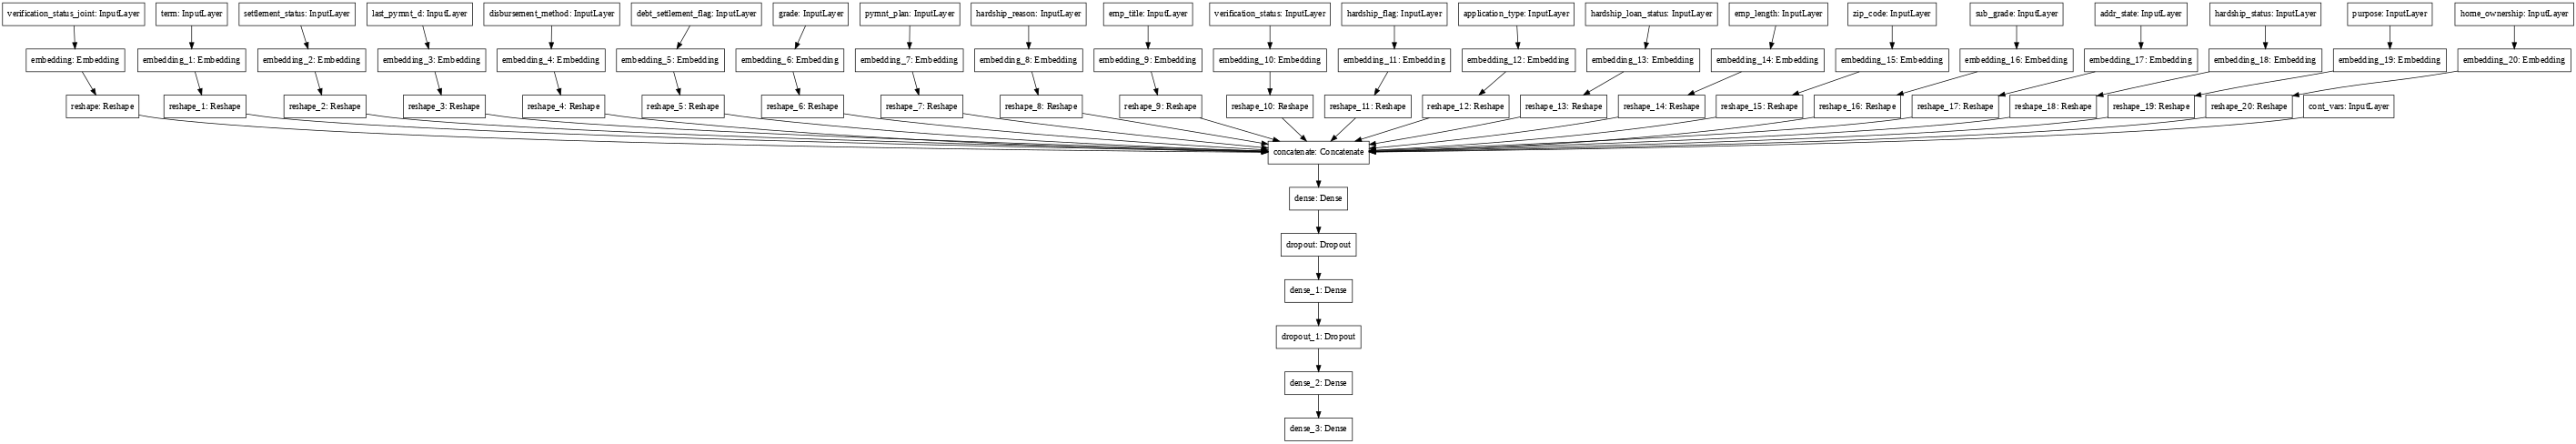

In [210]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model


SVG(model_to_dot(neural_model, dpi=50).create(prog='dot', format='svg'))

neural_visual_path = os.path.join(data_folder, 'neural_model_visual.png')
plot_model(neural_model, dpi=50, to_file=neural_visual_path)

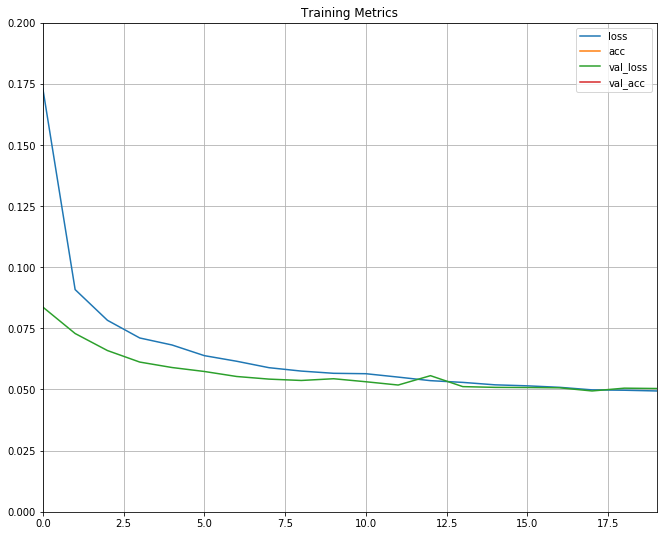

In [213]:
pd.DataFrame(hist.history).plot(figsize=(11, 9))
plt.grid(True)
plt.gca().set_ylim(0, 0.2) 
plt.title("Training Metrics")
plt.show()

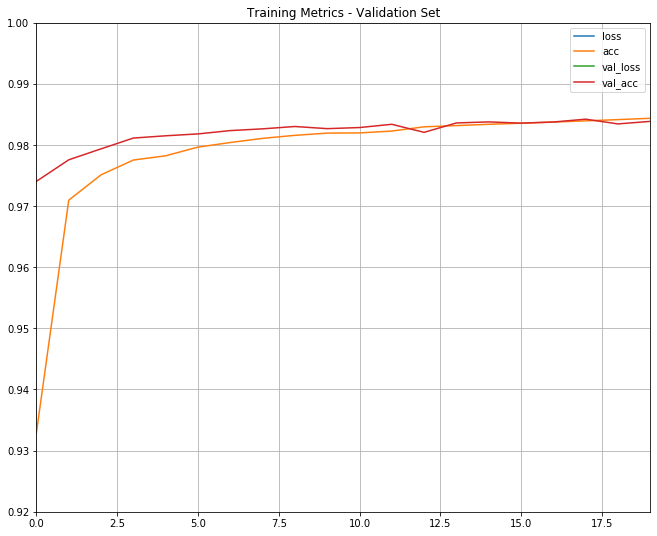

In [214]:
pd.DataFrame(hist.history).plot(figsize=(11, 9))
plt.grid(True)
plt.gca().set_ylim(0.92, 1.0) 
plt.title("Training Metrics - Validation Set")
plt.show()

#Evaluate


#### Evaluate Logistic Regression and Random Forest

In [0]:
#fit and cross validate
cross_train_models(X_train_tr, y_train, reset = True)
#train_models(X_train_tr, y_train, reset = True)

In [0]:
from IPython.display import display

In [231]:
fit_results = {}
for result in fit_cross_results:
  frame = pd.DataFrame.from_dict(fit_cross_results[result])
  fit_results[result] = frame
  display(result)
  display(frame)
  print("\n")


'LogisticRegression'

,fit_time,score_time,estimator,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,107.270679,0.353307,"LogisticRegression(C=1.0, class_weight=None, d...",0.944448,0.906411,0.991243,0.946931,0.980762
1,113.395245,0.357948,"LogisticRegression(C=1.0, class_weight=None, d...",0.944454,0.906167,0.991587,0.946954,0.980939
2,98.170788,0.355562,"LogisticRegression(C=1.0, class_weight=None, d...",0.944784,0.906681,0.991630,0.947255,0.980958


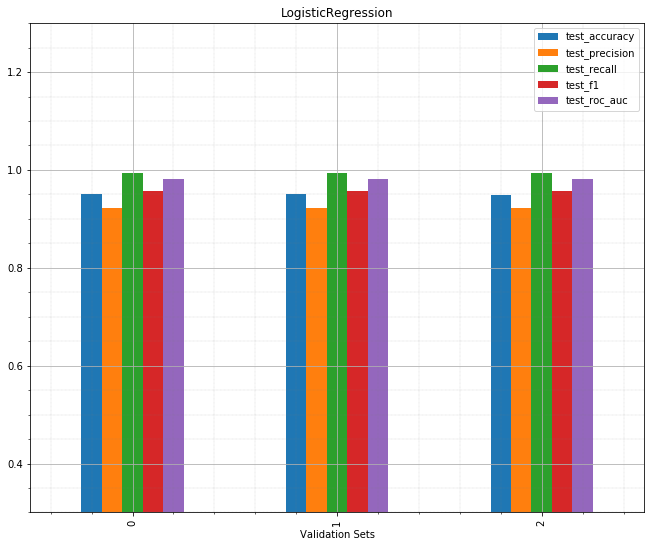

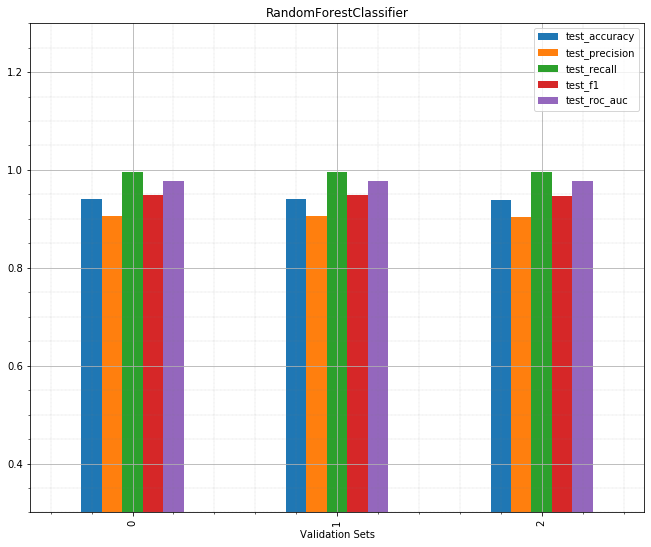

In [164]:
for result in fit_results:
  fig, ax = plt.subplots()
  fit_results[result][
    ['test_accuracy',	'test_precision','test_recall',	'test_f1',	'test_roc_auc']
  ].plot(kind='bar', title=result, grid=True, figsize=(11,9), ax=ax)
  ax.minorticks_on()
  ax.grid(which='minor', linestyle=':', linewidth='0.3', color='grey')
  ax.set_xlabel('Validation Sets')
  plt.grid(True)
  plt.gca().set_ylim(0.3, 1.3)

plt.show()

In [246]:
for key in tqdm(models):
  display(calc_metrics(key, models[key], X_test_tr, y_test ))






  0%|          | 0/2 [00:00<?, ?it/s]

{'LogisticRegression': [0.9450652962717306,
  0.9075735767004564,
  0.9910597835174513,
  0.9474811633433866,
  0.945065039909351]}






 50%|█████     | 1/2 [00:00<00:00,  3.58it/s]

{'LogisticRegression': [0.9450652962717306,
  0.9075735767004564,
  0.9910597835174513,
  0.9474811633433866,
  0.945065039909351],
 'RandomForestClassifier': [0.9367325667593764,
  0.8928327918822444,
  0.992609272409065,
  0.9400809759342057,
  0.9367322553158517]}






100%|██████████| 2/2 [00:06<00:00,  2.15s/it]






#### Evaluate Neural Network

In [0]:
def predict_classes(X):
  X_prep = prepare(X, fit=False)
  y_pred = neural_model.predict(X_prep)
  
  if y_pred.shape[-1] > 1:
    return y_pred.argmax(axis=-1)
  else:
    return (y_pred > 0.5).astype('int32')

In [0]:
y_pred_class = predict_classes(X_test)

In [259]:
calc_metrics('NeuralNetwork', neural_model, X_test_prepared, y_test, y_pred=y_pred_class )

{'LogisticRegression': [0.9450652962717306,
  0.9075735767004564,
  0.9910597835174513,
  0.9474811633433866,
  0.945065039909351],
 'NeuralNetwork': [0.8098688500833273,
  0.9468979598398739,
  0.6565596887645334,
  0.7754430313084236,
  0.8098697045922861],
 'RandomForestClassifier': [0.8098688500833273,
  0.9468979598398739,
  0.6565596887645334,
  0.7754430313084236,
  0.8098697045922861]}

[[86403  3303]
 [30809 58898]]


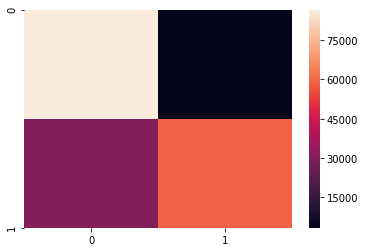

In [238]:
conf = confusion_matrix(y_test, y_pred_class)
print(conf)
sns.heatmap(conf)

In [0]:
from sklearn.metrics import classification_report

In [80]:
print(classification_report(y_test, y_pred_class, target_names=["Bad Loan", "Good Loan"], digits=5))

              precision    recall  f1-score   support

    Bad Loan    0.64325   0.98879   0.77944     89707
   Good Loan    0.98427   0.56130   0.71491    112133

    accuracy                        0.75129    201840
   macro avg    0.81376   0.77504   0.74717    201840
weighted avg    0.83271   0.75129   0.74359    201840



####Compare

In [0]:
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
model_names = []
for key in test_scores:
  model_names.append(key)

In [282]:
metrics = pd.DataFrame.from_dict(test_scores).T
metrics.columns = metric_names
metrics.head()

,Accuracy,Precision,Recall,F1,AUC
LogisticRegression,0.945065,0.907574,0.99106,0.947481,0.945065
RandomForestClassifier,0.809869,0.946898,0.65656,0.775443,0.809870
NeuralNetwork,0.809869,0.946898,0.65656,0.775443,0.809870


Text(0.5, 1.0, 'Test Performance')

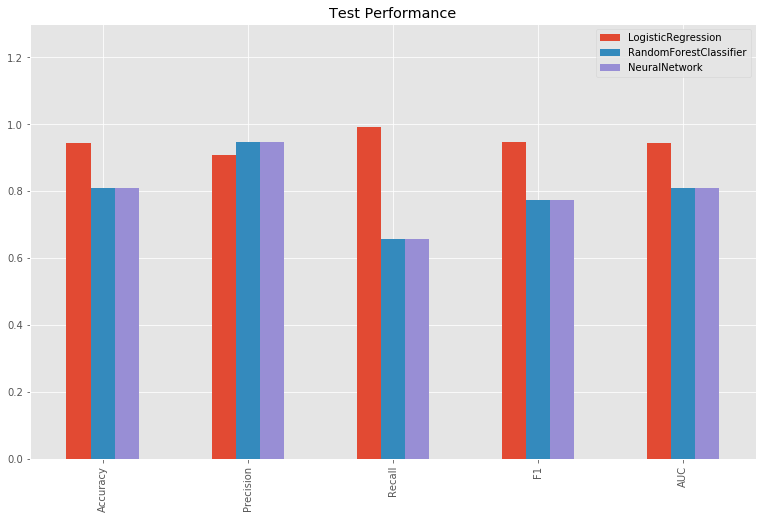

In [286]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (13,8)
metrics.T.plot.bar()
plt.legend(loc='upper right')
plt.ylim([0, 1.3])
plt.grid(True)
plt.title('Test Performance')